In [3]:
SERVICE_HOSTNAMES=!(kubectl get inferenceservice -n cifar10 tfserving-cifar10 -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_CIFAR10=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_CIFAR10)


tfserving-cifar10.cifar10.example.com


In [4]:
SERVICE_HOSTNAMES=!(kubectl get ksvc -n cifar10 drift-detector -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_VAEOD=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_VAEOD)

drift-detector.cifar10.example.com


In [5]:
CLUSTER_IP="localhost:8080"

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
import tensorflow as tf
tf.keras.backend.clear_session()

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis('off')
    plt.show()

def predict(X):
    formData = {
        'instances': X.tolist()
    }
    headers = {}
    headers["Host"] = SERVICE_HOSTNAME_CIFAR10
    res = requests.post('http://'+CLUSTER_IP+'/v1/models/tfserving-cifar10:predict', json=formData, headers=headers)
    if res.status_code == 200:
        j = res.json()
        if len(j["predictions"]) == 1:
            return classes[np.array(j["predictions"])[0].argmax()]
    else:
        print("Failed with ",res.status_code)
        return []

def drift(X):
    formData = {
        'instances': X.tolist()
    }
    headers = { "ce-namespace": "default","ce-modelid":"cifar10drift","ce-type":"io.seldon.serving.inference.request", \
                "ce-id":"1234","ce-source":"localhost","ce-specversion":"1.0"}
    headers["Host"] = SERVICE_HOSTNAME_VAEOD
    res = requests.post('http://'+CLUSTER_IP+'/', json=formData, headers=headers)
    if res.status_code == 200:
        od = res.json()
        return od
    else:
        print("Failed with ",res.status_code)
        return []


2023-05-04 11:49:28.857875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


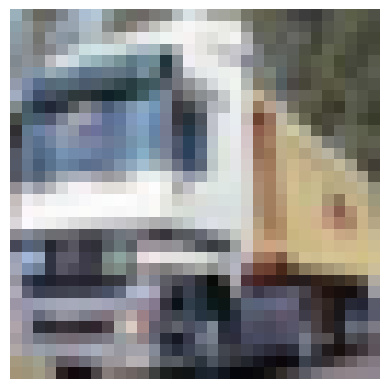

'truck'

In [7]:
idx = 1
X = X_train[idx:idx+1]
show(X)
predict(X)

In [8]:
!kubectl logs -n cifar10 $(kubectl get pod -n cifar10 -l app=hello-display -o jsonpath='{.items[0].metadata.name}')


In [9]:
from tqdm.notebook import tqdm
for i in tqdm(range(0,5000,100)):
    X = X_train[i:i+100]
    predict(X)

  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
res=!kubectl logs -n cifar10 $(kubectl get pod -n cifar10 -l app=hello-display -o jsonpath='{.items[0].metadata.name}')
data= []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[0]))
print("Drift",j["data"]["is_drift"]==1)


Drift False


In [11]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c
corruption = ['motion_blur']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255


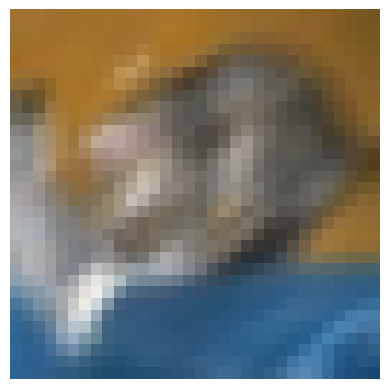

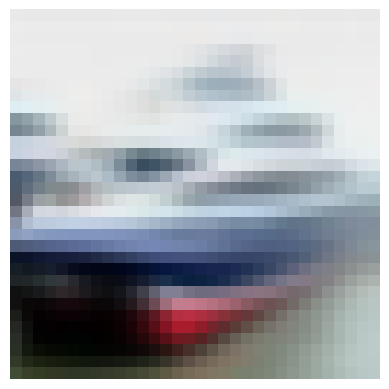

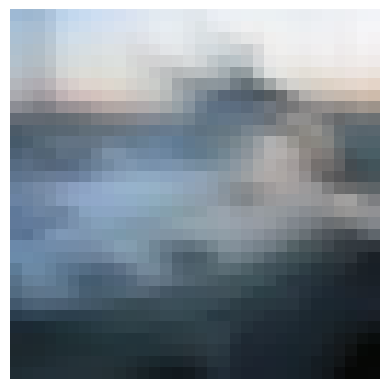

In [12]:
show(X_corr[0])
show(X_corr[1])
show(X_corr[2])

In [13]:
for i in tqdm(range(0,5000,100)):
    X = X_corr[i:i+100]
    predict(X)


  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
res=!kubectl logs -n cifar10 $(kubectl get pod -n cifar10 -l app=hello-display -o jsonpath='{.items[0].metadata.name}')
data= []
for i in range(0,len(res)):
    if res[i] == 'Data,':
        data.append(res[i+1])
j = json.loads(json.loads(data[-1]))
print("Drift",j["data"]["is_drift"]==1)


Drift True
